# Project 2
## Part 2 - Deep Learning abd Clutering of Image Data

Note that this notebook should run in Google colab.

In [ ]:
!pip install hdbscan
!pip install umap
!pip install umap-learn

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

# Added
import hdbscan

# Flowers Dataset and VGG Features

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

# Question 21



In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
print(num_features)

(3670, 4096) (3670,)
4096


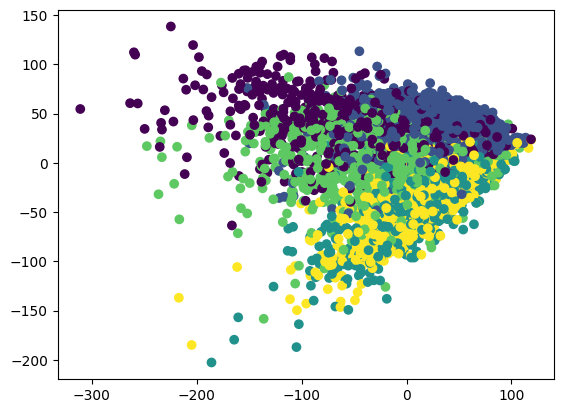

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

For question 25

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                # Forward pass
                outputs = self(X_)
                loss = criterion(outputs, y_)

                # Backward and optimize
                optimizer.zero_grad()  # Clear gradients
                loss.backward()  # Calculate gradients
                optimizer.step()  # Update weights

                #raise NotImplementedError
        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################

        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()  # Set the model to evaluation mode

        with torch.no_grad():  # No need to track gradients during evaluation
            predictions = self(X_test)
            _, predicted_labels = torch.max(predictions, 1)

            # Calculate accuracy
            correct_predictions = (predicted_labels == y_test).sum().item()
            total_predictions = y_test.size(0)
            accuracy = correct_predictions / total_predictions

            # Calculate precision, recall, and F1 score
            precision = precision_score(y_test.cpu(), predicted_labels.cpu(), average='weighted')
            recall = recall_score(y_test.cpu(), predicted_labels.cpu(), average='weighted')
            f1 = f1_score(y_test.cpu(), predicted_labels.cpu(), average='weighted')

        return accuracy, precision, recall, f1
        # raise NotImplementedError

# Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


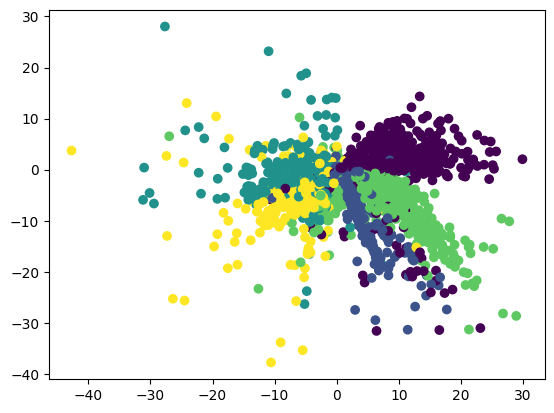

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

# Todo:


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import warnings

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    adjusted_rand_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import umap
import hdbscan
from itertools import product

warnings.filterwarnings("ignore")

# QUESTION 22:

In [ ]:

# Calculate the proportion of zero entries in the feature matrix
num_zeros = np.sum(f_all == 0)
total_elements = f_all.size
sparsity = num_zeros / total_elements

# Print the sparsity
print(f"Sparsity of features: {sparsity:.4f}")

# If the sparsity is very low, we can conclude the features are dense
if sparsity < 0.1:  # A threshold of 10% zero values is a typical benchmark for dense vs. sparse
    print("The features are dense.")
else:
    print("The features are sparse.")


Sparsity of features: 0.0000
The features are dense.


# QUESTION 23:

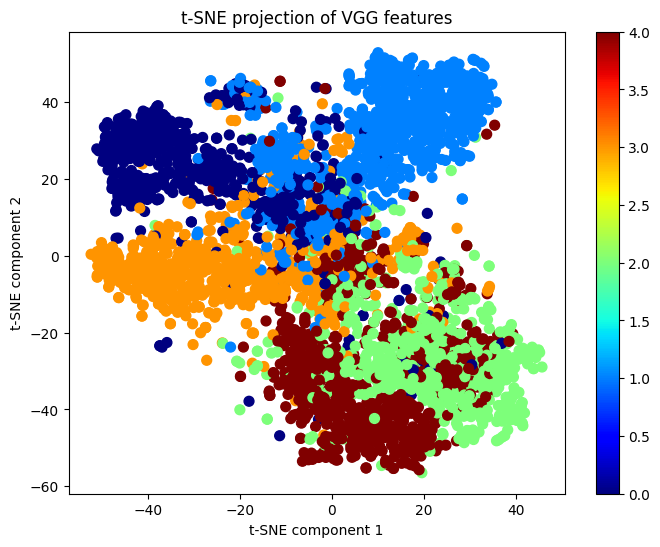

In [ ]:
# apply t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(f_all)

# plot the 2D projection
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all, cmap='jet', s=50)
plt.colorbar()
plt.title("t-SNE projection of VGG features")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

# QUESTION 24:

In [ ]:
class ClusteringAnalysis:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.results = {}

    def apply_dimensionality_reduction(self, X, method='none', n_components=50):
        if method == 'none':
            return X
        elif method == 'svd':
            svd = TruncatedSVD(n_components=n_components)
            return svd.fit_transform(X)
        elif method == 'pca':
            pca = PCA(n_components=n_components)
            return pca.fit_transform(X)
        elif method == 'umap':
            umap_model = umap.UMAP(n_components=n_components)
            return umap_model.fit_transform(X)
        elif method == 'autoencoder':
            autoencoder = Autoencoder(n_components=n_components).cuda()
            return autoencoder.fit_transform(X)

    def apply_clustering(self, X, method='kmeans', **params):
        if method == 'kmeans':
            kmeans = KMeans(n_clusters=params.get('n_clusters', 5))
            return kmeans.fit_predict(X)
        elif method == 'agglomerative':
            agg = AgglomerativeClustering(n_clusters=params.get('n_clusters', 5))
            return agg.fit_predict(X)
        elif method == 'hdbscan':
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=params.get('min_cluster_size', 15),
                min_samples=params.get('min_samples', 10)
            )
            return clusterer.fit_predict(X)

    def run_analysis(self):
        # Dimensionality reduction methods
        dim_reduction_methods = {
            'none': {'n_components': None},
            'svd': {'n_components': 50},
            'pca': {'n_components': 50},
            'umap': {'n_components': 50},
            'autoencoder': {'n_components': 50}
        }

        # Clustering methods
        clustering_methods = {
            'kmeans': {'n_clusters': 5},
            'agglomerative': {'n_clusters': 5},
            'hdbscan': {
                'min_cluster_size': [10, 15, 20],
                'min_samples': [5, 10, 15]
            }
        }

        # Run all combinations
        results_list = []
        for dim_method, dim_params in dim_reduction_methods.items():
            # Apply dimensionality reduction
            X_reduced = self.apply_dimensionality_reduction(
                self.X,
                method=dim_method,
                n_components=dim_params['n_components']
            )

            # apply clustering methods
            for clust_method, clust_params in clustering_methods.items():
                if clust_method == 'hdbscan':
                    # Grid search for HDBSCAN parameters
                    best_ari = -1
                    best_params = None

                    for min_cluster_size, min_samples in product(
                        clust_params['min_cluster_size'],
                        clust_params['min_samples']
                    ):
                        labels = self.apply_clustering(
                            X_reduced,
                            method='hdbscan',
                            min_cluster_size=min_cluster_size,
                            min_samples=min_samples
                        )

                        ari = adjusted_rand_score(self.y, labels)
                        if ari > best_ari:
                            best_ari = ari
                            best_params = {
                                'min_cluster_size': min_cluster_size,
                                'min_samples': min_samples
                            }

                    results_list.append({
                        'Dimensionality Reduction': dim_method,
                        'Clustering Algorithm': clust_method,
                        'ARI Score': best_ari,
                        'Best Parameters': best_params
                    })
                else:
                    # Regular clustering methods
                    labels = self.apply_clustering(
                        X_reduced,
                        method=clust_method,
                        **clust_params
                    )
                    ari = adjusted_rand_score(self.y, labels)
                    results_list.append({
                        'Dimensionality Reduction': dim_method,
                        'Clustering Algorithm': clust_method,
                        'ARI Score': ari,
                        'Best Parameters': clust_params
                    })

        # Convert results to DataFrame
        self.results_df = pd.DataFrame(results_list)

    def print_results(self):
        # Sort DataFrame by ARI Score
        df_sorted = self.results_df.sort_values('ARI Score', ascending=False)

        # Format ARI Score to 4 decimal places
        df_sorted['ARI Score'] = df_sorted['ARI Score'].map('{:.4f}'.format)

        # convert parameters to string format for better display
        df_sorted['Best Parameters'] = df_sorted['Best Parameters'].apply(
            lambda x: ', '.join([f'{k}={v}' for k, v in x.items()])
        )

        print("\nClustering Results Sorted by ARI Score:")
        print(df_sorted.to_string(index=False))

        # Get best result
        best_result = df_sorted.iloc[0]
        print("\nBest Result:")
        print(f"Dimensionality Reduction: {best_result['Dimensionality Reduction']}")
        print(f"Clustering Algorithm: {best_result['Clustering Algorithm']}")
        print(f"ARI Score: {best_result['ARI Score']}")
        print(f"Parameters: {best_result['Best Parameters']}")

        return df_sorted


In [ ]:
# This part takes long time
analyzer = ClusteringAnalysis(f_all, y_all)
analyzer.run_analysis()
results_df = analyzer.print_results()
results_df

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Clustering Results Sorted by ARI Score:
Dimensionality Reduction Clustering Algorithm ARI Score                     Best Parameters
                    umap               kmeans    0.3970                        n_clusters=5
                    umap        agglomerative    0.3598                        n_clusters=5
                    umap              hdbscan    0.3344 min_cluster_size=10, min_samples=15
             autoencoder        agglomerative    0.2651                        n_clusters=5
             autoencoder               kmeans    0.2260                        n_clusters=5
                    none        agglomerative    0.2184                        n_clusters=5
                     svd        agglomerative    0.2102                        n_clusters=5
                     pca        agglomerative    0.2040                        n_clusters=5
                     pca               kmeans    0.1955                        n_clusters=5
                     svd               

,Dimensionality Reduction,Clustering Algorithm,ARI Score,Best Parameters
9,umap,kmeans,0.3970,n_clusters=5
10,umap,agglomerative,0.3598,n_clusters=5
11,umap,hdbscan,0.3344,"min_cluster_size=10, min_samples=15"
13,autoencoder,agglomerative,0.2651,n_clusters=5
12,autoencoder,kmeans,0.2260,n_clusters=5
1,none,agglomerative,0.2184,n_clusters=5
4,svd,agglomerative,0.2102,n_clusters=5
7,pca,agglomerative,0.2040,n_clusters=5
6,pca,kmeans,0.1955,n_clusters=5
3,svd,kmeans,0.1934,n_clusters=5


# QUESTION 25

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:

# Define dimensionality reduction functions
def apply_pca(X, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)

def apply_umap(X, n_components=50):
    umap_model = umap.UMAP(n_components=n_components)
    return umap_model.fit_transform(X)


# Initialize results dictionary
results = {'Original': {}, 'PCA': {}, 'UMAP': {}, 'Autoencoder': {}}

# Train and evaluate the MLP on the original data
mlp = MLP(num_features=X_train_scaled.shape[1])
mlp.train(X_train_scaled, y_train)
accuracy, precision, recall, f1 = mlp.eval(X_test_scaled, y_test)
results['Original']['MLP'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

# Train and evaluate the MLP on reduced data
methods = ['PCA', 'UMAP', 'Autoencoder']
for method in methods:
    if method == 'PCA':
        X_train_reduced = apply_pca(X_train_scaled, n_components=50)
        X_test_reduced = apply_pca(X_test_scaled, n_components=50)
    elif method == 'UMAP':
        X_train_reduced = apply_umap(X_train_scaled, n_components=50)
        X_test_reduced = apply_umap(X_test_scaled, n_components=50)
    elif method == 'Autoencoder':
        autoencoder = Autoencoder(n_components=50).cuda()
        X_train_reduced = autoencoder.fit_transform(X_train_scaled)
        X_test_reduced = autoencoder.fit_transform(X_test_scaled)

    # Train and evaluate MLP for each dimensionality reduction method
    mlp = MLP(num_features=X_train_reduced.shape[1])
    mlp.train(X_train_reduced, y_train)
    accuracy, precision, recall, f1 = mlp.eval(X_test_reduced, y_test)
    results[method]['MLP'] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# print and compare results
for method in results:
    print(f"\nResults for {method} reduction:")
    metrics = results[method]['MLP']
    print(f"MLP: Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


Results for Original reduction:
MLP: Accuracy: 0.9033, Precision: 0.9036, Recall: 0.9033, F1: 0.9032

Results for PCA reduction:
MLP: Accuracy: 0.6226, Precision: 0.6310, Recall: 0.6226, F1: 0.6242

Results for UMAP reduction:
MLP: Accuracy: 0.1826, Precision: 0.0333, Recall: 0.1826, F1: 0.0564

Results for Autoencoder reduction:
MLP: Accuracy: 0.0613, Precision: 0.1256, Recall: 0.0613, F1: 0.0640
